# Codigo para crear tubos 


# Geometria FF

Radio ≈ 54.55 px (diámetro ≈ 109.09 px)


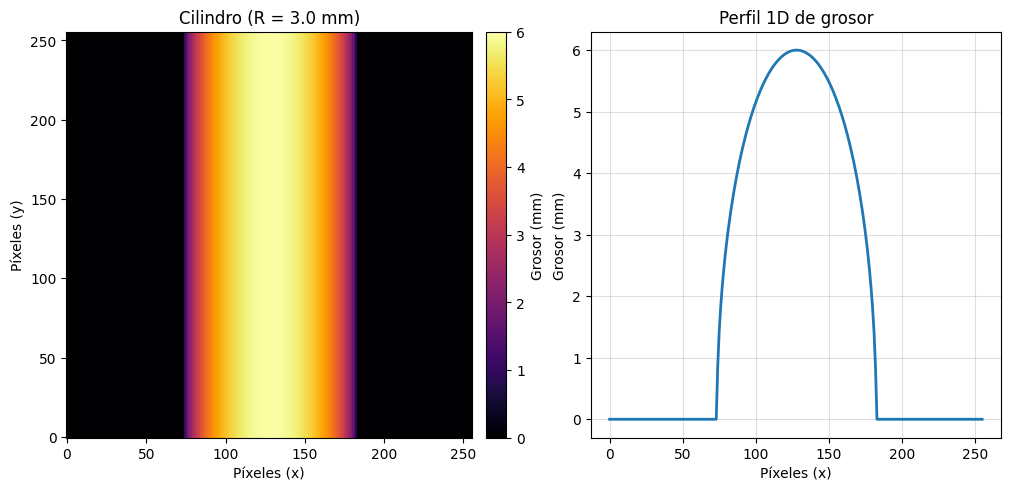

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parámetros del detector y del cilindro ---
N = 256                  # 256x256 píxeles
pix_mm = 0.055           # tamaño de píxel en mm (55 µm)
R_mm = 3               # radio físico = 1 mm
xc = yc = N // 2         # centro en píxeles

# --- Radio en píxeles ---
R_px = R_mm / pix_mm     # ~18.18 píxeles
print(f"Radio ≈ {R_px:.2f} px (diámetro ≈ {2*R_px:.2f} px)")

# --- Eje x (en píxeles, centrado) ---
x_px = np.arange(N) - xc

# --- Perfil 1D de grosor (mm) ---
t_line = np.zeros(N, float)
mask = np.abs(x_px) <= R_px
t_line[mask] = 2.0 * np.sqrt((R_px * pix_mm)**2 - (x_px[mask] * pix_mm)**2)  # mm

# --- Imagen 2D (apilada) ---
t_img = np.tile(t_line, (N, 1))  # mm


fig = plt.figure(figsize=(10, 4.8), constrained_layout=True)
gs = fig.add_gridspec(nrows=1, ncols=3, width_ratios=[1, 0.05, 1])

# Izquierda: imagen 2D (mismo tamaño que el de la derecha)
ax_img = fig.add_subplot(gs[0, 0])
im = ax_img.imshow(
    t_img, origin='lower', cmap='inferno', interpolation='nearest',
    vmin=0, vmax=2*R_mm, aspect='equal'  # píxel cuadrado
)
ax_img.set_xlabel('Píxeles (x)')
ax_img.set_ylabel('Píxeles (y)')
ax_img.set_title('Cilindro (R = 3.0 mm)')

# Colorbar en columna angosta (no altera el ancho de los ejes principales)
cax = fig.add_subplot(gs[0, 1])
cb = fig.colorbar(im, cax=cax)
cb.set_label('Grosor (mm)')

# Derecha: perfil 1D (mismo tamaño que la imagen)
ax_prof = fig.add_subplot(gs[0, 2])
ax_prof.plot(np.arange(N), t_line, lw=2)
ax_prof.grid(True, alpha=0.4)
ax_prof.set_xlabel('Píxeles (x)')
ax_prof.set_ylabel('Grosor (mm)')
ax_prof.set_title('Perfil 1D de grosor')

plt.show()

# Imagen de intensidad FF

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


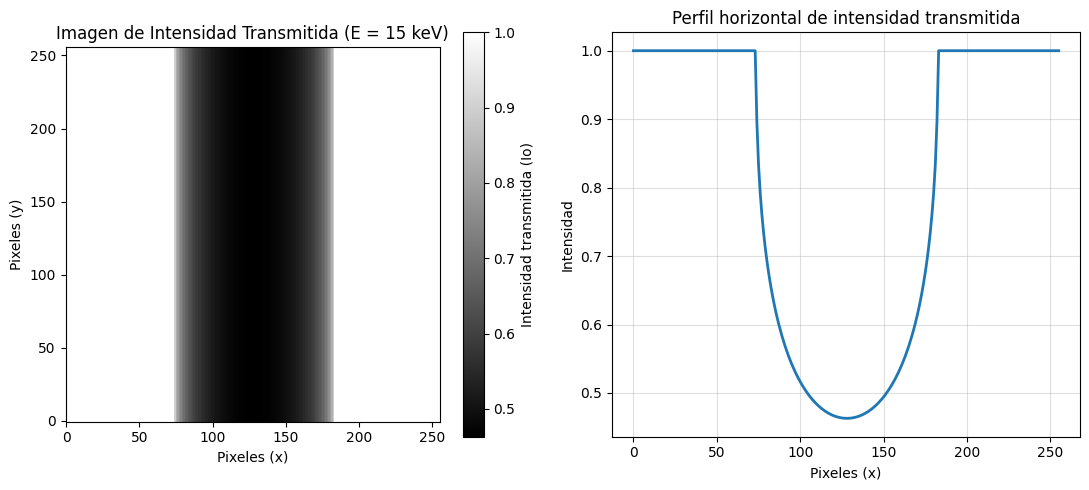

In [23]:
#Parametros-------------------
E_keV = 15  #Energía en keV
c = 2.99792458e8 #m/s
h_barr = 1.054571817e-34 #joules*s
E_J = E_keV * 1.602e-16
k = E_J/(h_barr*c) #numero de onda 1/m
B_pmma = 8.4447E-10 #Cambiar con la energía
t_img_m = t_img * 1e-3 #grosor de mm a m del cilindro solido de pmma

I0 =  np.exp(-2*k*B_pmma*t_img_m)  #intensidad
#np.savetxt(fr"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones Python\FF\FF{E_keV:.0f}keV.txt",I0)
print(I0)
# --- Visualización ---
fig, axes = plt.subplots(1, 2, figsize=(11,5))  # 1 fila, 2 columnas

# --- Imagen 2D ---
im = axes[0].imshow(
    I0, origin='lower', cmap='gray', interpolation='nearest',
    vmin=np.min(I0), vmax=np.max(I0), aspect='equal'
)
fig.colorbar(im, ax=axes[0], label='Intensidad transmitida (Io)')
axes[0].set_title(f'Imagen de Intensidad Transmitida (E = {E_keV} keV)')
axes[0].set_xlabel('Pixeles (x)')
axes[0].set_ylabel('Pixeles (y)')

# --- Perfil 1D ---
axes[1].plot(np.arange(I0.shape[1]), I0[I0.shape[0]//2, :], lw=2)
axes[1].grid(True, alpha=0.4)
axes[1].set_xlabel('Pixeles (x)')
axes[1].set_ylabel('Intensidad')
axes[1].set_title('Perfil horizontal de intensidad transmitida')
#plt.savefig(fr"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones Python\Imagenes FF\FF{E_keV:.0f}keV.png", dpi=300)
# --- Ajuste final ---
plt.tight_layout()
plt.show()




# Geometria RAW

Chequeo igualdad t_total vs t_big (máx |dif|): 8.881784197001252e-16


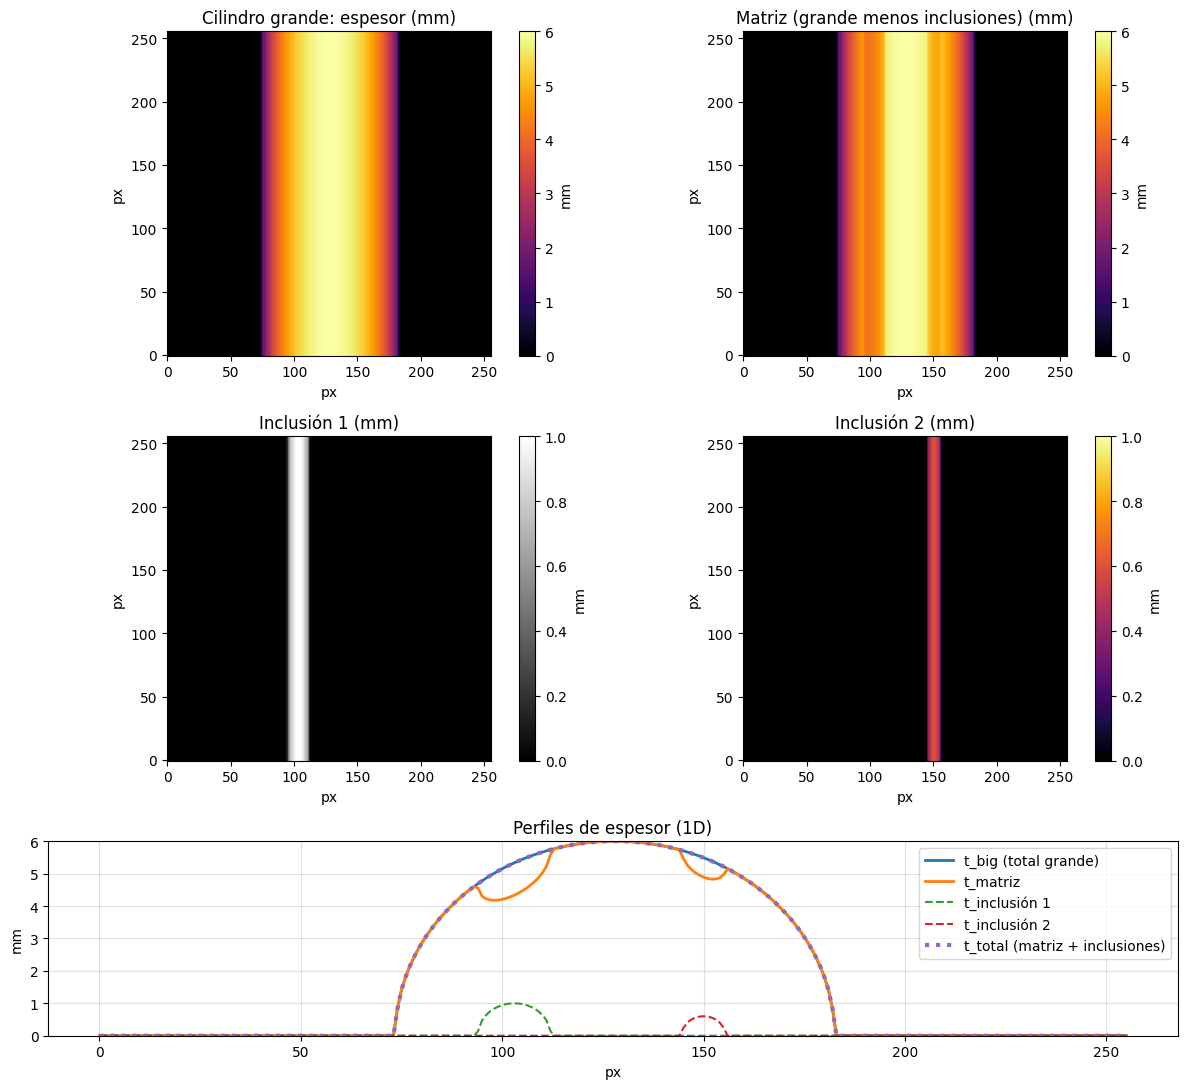

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Parámetros del detector ----------------
N = 256               # 256x256 píxeles
pix_mm = 0.055        # 55 µm en mm
xc = yc = N // 2      # centro en píxeles

# ---------------- Geometría de cilindros (en mm) ----------------
R_big_mm = 3       # radio cilindro grande
# dos cilindros internos (centros en píxeles sobre x; radios en mm)
inclusions = [
    {"xc_px": xc - 25, "R_mm": 0.50},   # inclusión 1
    {"xc_px": xc + 22, "R_mm": 0.30},   # inclusión 2
]

# ---------------- Eje x en mm (centrado) ----------------
x_px = np.arange(N)
x_mm = (x_px - xc) * pix_mm

def thickness_semicircle(x_mm, xc_px, R_mm, pix_mm):
    """Espesor 1D: 2*sqrt(R^2 - (x-xc)^2) dentro del cilindro; 0 fuera. (mm)"""
    dx_mm = (x_px - xc_px) * pix_mm
    t = np.zeros_like(dx_mm, dtype=float)
    mask = np.abs(dx_mm) <= R_mm
    t[mask] = 2.0 * np.sqrt(R_mm**2 - dx_mm[mask]**2)
    return t

# ---------------- Perfiles 1D de espesor ----------------
t_big = thickness_semicircle(x_mm, xc, R_big_mm, pix_mm)

# inclusiones
t_in_list = [thickness_semicircle(x_mm, inc["xc_px"], inc["R_mm"], pix_mm) for inc in inclusions]
t_in_sum = np.sum(t_in_list, axis=0)

# Espesor de la matriz (PMMA grande) tras restar inclusiones (recortar a >=0)
t_matrix = np.clip(t_big - t_in_sum, 0.0, None)

# Espesor total (de verificación): debe ser igual a t_big
t_total = t_matrix + t_in_sum

print("Chequeo igualdad t_total vs t_big (máx |dif|):", np.max(np.abs(t_total - t_big)))

# ---------------- Mapas 2D por apilado ----------------
t_big_img    = np.tile(t_big,    (N, 1))
t_matrix_img = np.tile(t_matrix, (N, 1))
t_in_imgs    = [np.tile(ti, (N, 1)) for ti in t_in_list]
t_total_img  = np.tile(t_total,  (N, 1))



# ---------------- Visualización ----------------
vmax = 2*R_big_mm  # escala 0–2R_big (mm)
cmap = "inferno"

# Figura única con 5 plots (2x2 imágenes + 1 perfil 1D)
fig = plt.figure(figsize=(12, 11))
gs = fig.add_gridspec(nrows=3, ncols=2, height_ratios=[1, 1, 0.6])

# Ejes para las 4 imágenes
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Eje para el perfil 1D (abajo, ocupa 2 columnas)
ax5 = fig.add_subplot(gs[2, :])

# ---------------- Visualización (idéntico a tu configuración) ----------------
# vmax, cmap ya definidos fuera (como en tu código)

im1 = ax1.imshow(t_big_img, origin='lower', cmap=cmap, interpolation='nearest',
                 vmin=0, vmax=vmax, aspect='equal')
ax1.set_title('Cilindro grande: espesor (mm)')
plt.colorbar(im1, ax=ax1, label='mm')
ax1.set_xlabel('px'); ax1.set_ylabel('px')

im2 = ax2.imshow(t_matrix_img, origin='lower', cmap=cmap, interpolation='nearest',
                 vmin=0, vmax=vmax, aspect='equal')
ax2.set_title('Matriz (grande menos inclusiones) (mm)')
plt.colorbar(im2, ax=ax2, label='mm')
ax2.set_xlabel('px'); ax2.set_ylabel('px')

im3 = ax3.imshow(t_in_imgs[0], origin='lower', cmap="gray", interpolation='nearest',
                 vmin=0, vmax=1, aspect='equal')
ax3.set_title('Inclusión 1 (mm)')
plt.colorbar(im3, ax=ax3, label='mm')
ax3.set_xlabel('px'); ax3.set_ylabel('px')

im4 = ax4.imshow(t_in_imgs[1], origin='lower', cmap=cmap, interpolation='nearest',
                 vmin=0, vmax=1, aspect='equal')
ax4.set_title('Inclusión 2 (mm)')
plt.colorbar(im4, ax=ax4, label='mm')
ax4.set_xlabel('px'); ax4.set_ylabel('px')

# ---------------- Perfil 1D comparativo (idéntico a tu configuración) ----------------
ax5.plot(t_big,    label='t_big (total grande)', lw=2)
ax5.plot(t_matrix, label='t_matriz', lw=2)
ax5.plot(t_in_list[0], '--', label='t_inclusión 1')
ax5.plot(t_in_list[1], '--', label='t_inclusión 2')
ax5.plot(t_total, ':', label='t_total (matriz + inclusiones)', lw=3)
ax5.set_ylim(0, vmax)
ax5.grid(True, alpha=0.4); ax5.legend()
ax5.set_xlabel('px'); ax5.set_ylabel('mm'); ax5.set_title('Perfiles de espesor (1D)')

plt.tight_layout()
plt.show()


# Imagen de intensidad para RAW

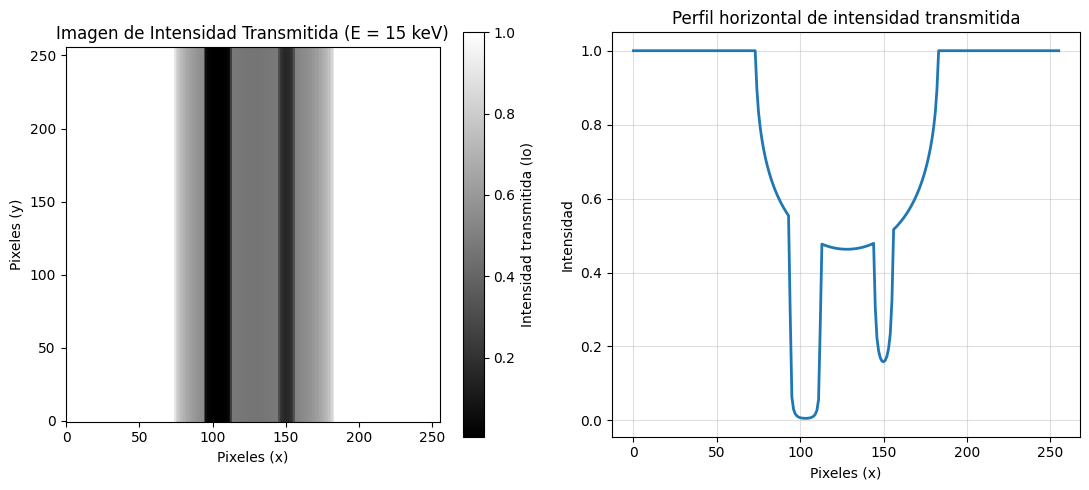

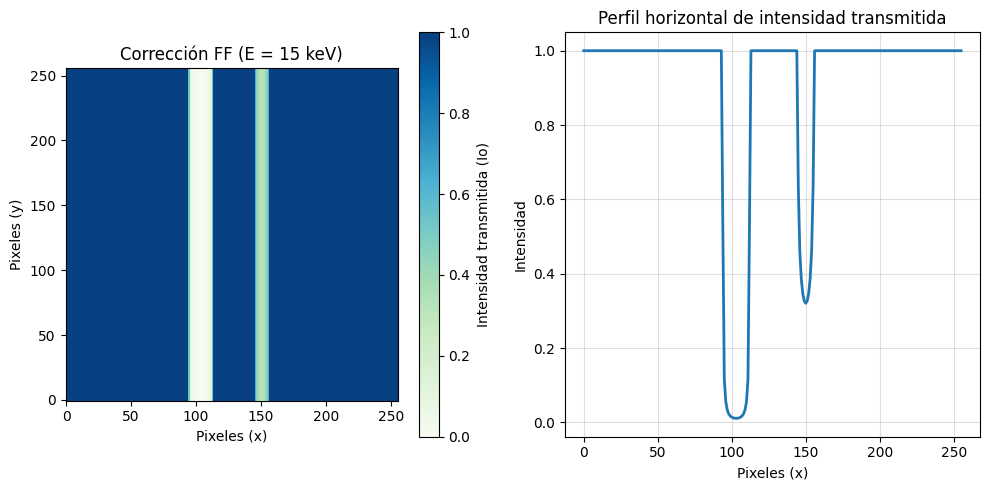

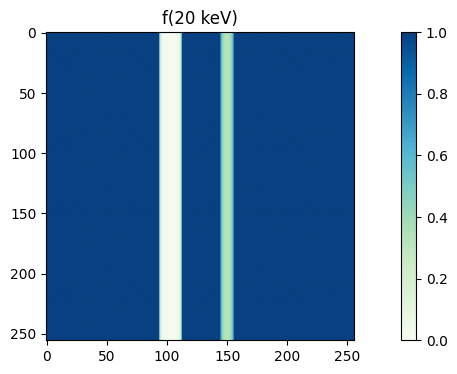

In [20]:
#Matrices de grosor
inclusion_1 = t_in_imgs[0]* 1e-3 #grosor de mm a m---Ha
inclusion_2 = t_in_imgs[1]* 1e-3 #grosor de mm a m---Al2O3
t_img_m = t_img * 1e-3 #grosor de mm a m 
#Parametros-------------------
E_keV = 15  #Energía en keV
c = 2.99792458e8 #m/s
h_barr = 1.054571817e-34 #joules*s
E_J = E_keV * 1.602e-16
k = E_J/(h_barr*c) #numero de onda 1/m
B_pmma = 8.4447E-10 #Cambiar dependiendo de la energía
Mu_Alumina = 0.20249E+02*100 #1/m Cambiar dependiendo de la energía
B_Alumina = Mu_Alumina/(2*k)
B_HA = 	3.0579E-08 #Cambiar dependiendo de la energía

#Intensidad 
I = np.exp(-2 * k * (B_pmma * (t_img_m - inclusion_2 - inclusion_1)+ B_Alumina * inclusion_2 + B_HA * inclusion_1))
#np.savetxt(fr"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones Python\RAW\RAW{E_keV:.0f}keV.txt",I)

# --- Visualización ---
fig, axes = plt.subplots(1, 2, figsize=(11,5))  # 1 fila, 2 columnas

# --- Imagen 2D ---
im = axes[0].imshow(
    I, origin='lower', cmap='gray', interpolation='nearest',
    vmin=np.min(I), vmax=np.max(I), aspect='equal'
)
fig.colorbar(im, ax=axes[0], label='Intensidad transmitida (Io)')
axes[0].set_title(f'Imagen de Intensidad Transmitida (E = {E_keV} keV)')
axes[0].set_xlabel('Pixeles (x)')
axes[0].set_ylabel('Pixeles (y)')

# --- Perfil 1D ---
axes[1].plot(np.arange(I.shape[1]), I[I.shape[0]//2, :], lw=2)
axes[1].grid(True, alpha=0.4)
axes[1].set_xlabel('Pixeles (x)')
axes[1].set_ylabel('Intensidad')
axes[1].set_title('Perfil horizontal de intensidad transmitida')
#plt.savefig(fr"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones Python\Imagenes RAW\RAW{E_keV:.0f}keV.png", dpi=300)
# --- Ajuste final ---
plt.tight_layout()
plt.show()

#Corrección de flat field-----------------------------------------------------------------------------------------------------------------
Corrección = I/I0

#np.savetxt(fr"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones Python\Corrección\Corrección_FF{E_keV:.0f}keV.txt",Corrección)


fig, axes = plt.subplots(1, 2, figsize=(10,5))  # 1 fila, 2 columnas

# --- Imagen 2D ---
im = axes[0].imshow(
    Corrección, origin='lower', cmap='GnBu', interpolation='nearest',
    vmin=0, vmax=1, aspect='equal'
)
fig.colorbar(im, ax=axes[0], label='Intensidad transmitida (Io)')
axes[0].set_title(f'Corrección FF (E = {E_keV} keV)')
axes[0].set_xlabel('Pixeles (x)')
axes[0].set_ylabel('Pixeles (y)')

# --- Perfil 1D ---
axes[1].plot(np.arange(Corrección.shape[1]), Corrección[Corrección.shape[0]//2, :], lw=2)
axes[1].grid(True, alpha=0.4)
axes[1].set_xlabel('Pixeles (x)')
axes[1].set_ylabel('Intensidad')
axes[1].set_title('Perfil horizontal de intensidad transmitida')
#plt.savefig(fr"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones Python\Imagenes Corrección\Corrección_FF{E_keV:.0f}keV.png", dpi=300)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12,4))
plt.imshow(Corrección, cmap='GnBu',vmin=0, vmax=1)
plt.title("f(20 keV)")
plt.axis('on')
plt.colorbar()



# Tubo Simulaciones Geant4

máx |t_total - t_big| = 8.881784197001252e-16


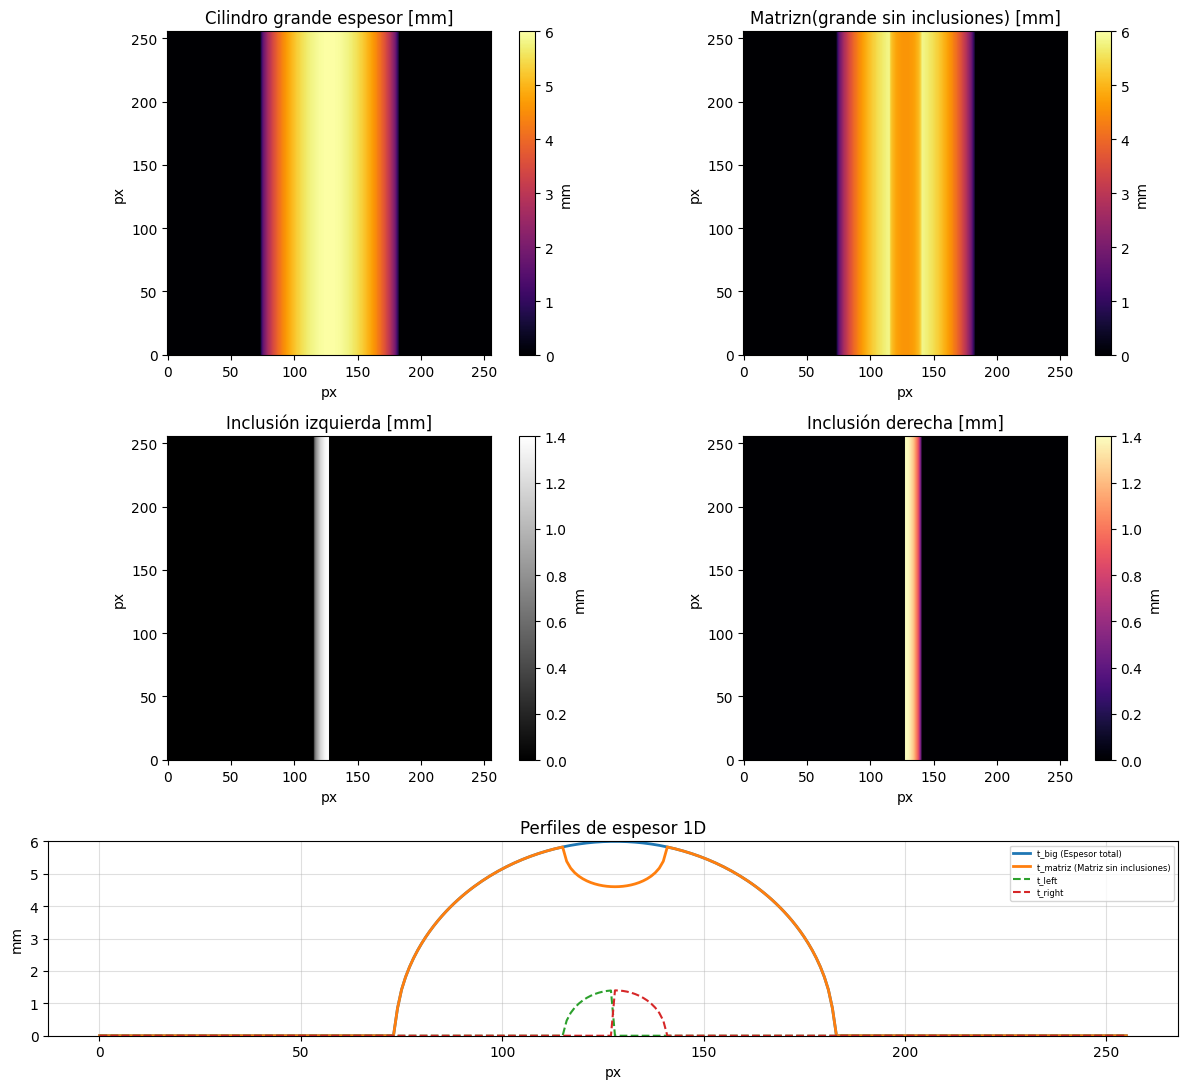

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Parámetros del detector ----------------
N = 256                 # 256x256 píxeles
pix_mm = 0.055          # 55 µm en mm
xc = yc = N // 2        # centro en píxeles

# ---------------- Geometría (mm) ----------------
R_big_mm   = 3.0        # radio cilindro grande (PMMA)
R_inner_mm = 0.7        # radio del cilindro interno que se parte en dos (Alúmina/HA)

# ---------------- Utilidades ----------------
x_px = np.arange(N)
x_mm = (x_px - xc) * pix_mm

def thickness_circle_1d(x_px, xc_px, R_mm, pix_mm):
    """Espesor 1D (mm) de un cilindro de radio R_mm centrado en xc_px."""
    dx_mm = (x_px - xc_px) * pix_mm
    t = np.zeros_like(dx_mm, dtype=float)
    mask = np.abs(dx_mm) <= R_mm
    t[mask] = 2.0 * np.sqrt(R_mm**2 - dx_mm[mask]**2)
    return t

# ---------------- Perfiles 1D ----------------
t_big   = thickness_circle_1d(x_px, xc, R_big_mm,   pix_mm)   # PMMA grande
t_inner = thickness_circle_1d(x_px, xc, R_inner_mm, pix_mm)   # círculo interno (2 mm)

# Partición en dos medios cilindros (infinito en Y)
left_mask  = x_px < xc   # mitad izquierda (incluye el centro)
right_mask = x_px >= xc   # mitad derecha (incluye el centro)

t_left  = np.where(left_mask,  t_inner, 0.0)   # Alúmina
t_right = np.where(right_mask, t_inner, 0.0)   # HA

# Matriz PMMA = grande - inclusiones (recortado a ≥0 por seguridad numérica)
t_matrix = np.clip(t_big - (t_left + t_right), 0.0, None)

# Chequeo de consistencia
t_total = t_matrix + t_left + t_right
print("máx |t_total - t_big| =", np.max(np.abs(t_total - t_big)))

# ---------------- Mapas 2D (apilado en Y) ----------------
t_big_img    = np.tile(t_big,    (N, 1))      # PMMA total
t_matrix_img = np.tile(t_matrix, (N, 1))      # PMMA matriz (sin inclusiones)
t_left_img   = np.tile(t_left,   (N, 1))      # Alúmina (medio cilindro izq.)
t_right_img  = np.tile(t_right,  (N, 1))      # HA (medio cilindro der.)
t_total_img  = np.tile(t_total,  (N, 1))      # Verificación

# ---------------- Visualización ----------------
fig = plt.figure(figsize=(12, 11))
gs = fig.add_gridspec(nrows=3, ncols=2, height_ratios=[1, 1, 0.6])

# Ejes para las 4 imágenes
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Eje para el perfil 1D (abajo, ocupa 2 columnas)
ax5 = fig.add_subplot(gs[2, :])

# ---------------- Visualización ----------------
vmax_big   = 2 * R_big_mm
vmax_inner = 2 * R_inner_mm

im1 = ax1.imshow(t_big_img, origin='lower', cmap='inferno',
                 vmin=0, vmax=vmax_big, aspect='equal')
ax1.set_title('Cilindro grande espesor [mm]'); fig.colorbar(im1, ax=ax1, label='mm')
ax1.set_xlabel('px'); ax1.set_ylabel('px')

im2 = ax2.imshow(t_matrix_img, origin='lower', cmap='inferno',
                 vmin=0, vmax=vmax_big, aspect='equal')
ax2.set_title('Matrizn(grande sin inclusiones) [mm]'); fig.colorbar(im2, ax=ax2, label='mm')
ax2.set_xlabel('px'); ax2.set_ylabel('px')

im3 = ax3.imshow(t_left_img, origin='lower', cmap='gray',
                 vmin=0, vmax=vmax_inner, aspect='equal')
ax3.set_title('Inclusión izquierda [mm]'); fig.colorbar(im3, ax=ax3, label='mm')
ax3.set_xlabel('px'); ax3.set_ylabel('px')

im4 = ax4.imshow(t_right_img, origin='lower', cmap='magma',
                 vmin=0, vmax=vmax_inner, aspect='equal')
ax4.set_title('Inclusión derecha [mm]'); fig.colorbar(im4, ax=ax4, label='mm')
ax4.set_xlabel('px'); ax4.set_ylabel('px')

# ---------------- Perfil 1D comparativo ----------------
ax5.plot(t_big,    label='t_big (Espesor total)', lw=2)
ax5.plot(t_matrix, label='t_matriz (Matriz sin inclusiones)', lw=2)
ax5.plot(t_left,   '--', label='t_left')
ax5.plot(t_right,  '--', label='t_right')
ax5.set_ylim(0, vmax_big)
ax5.grid(True, alpha=0.4)
ax5.legend(fontsize=6)
ax5.set_xlabel('px'); ax5.set_ylabel('mm'); ax5.set_title('Perfiles de espesor 1D')

plt.tight_layout()
plt.show()

# Imagen de intensidad para Geometria Geant4

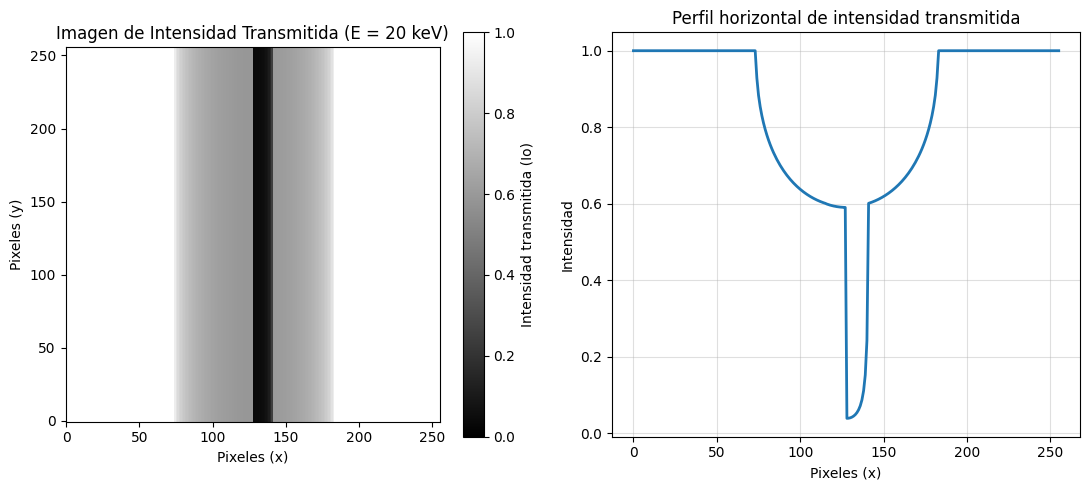

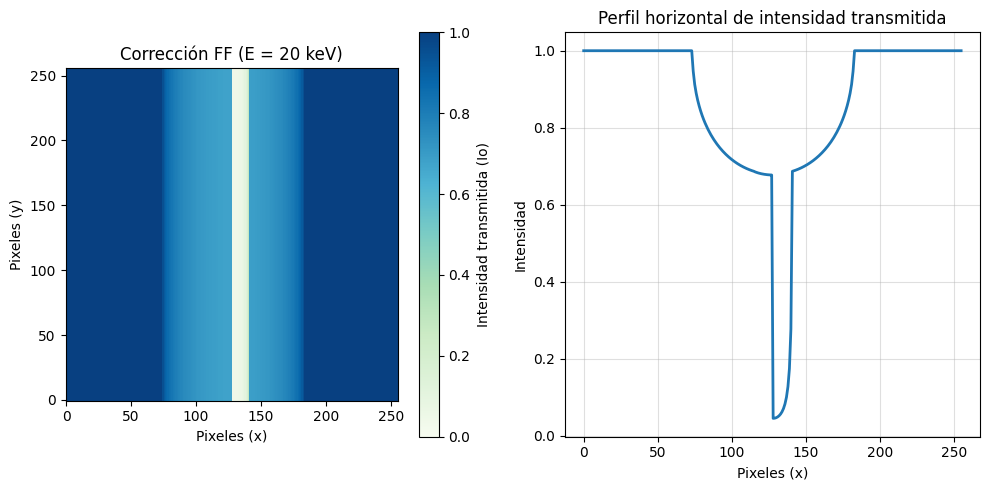

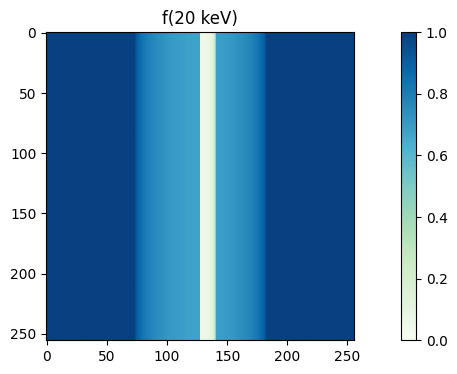

In [13]:
#Matrices de grosor
semicilindro_izquierdo = t_left_img* 1e-3 #grosor de mm a m--Al2O3
semicilindro_derecho = t_right_img* 1e-3 #grosor de mm a m---HA
t_img_m1 = t_big_img * 1e-3 #grosor de mm a m 
#Parametros-------------------
E_keV = 20 #Energía en keV
c = 2.99792458e8 #m/s
h_barr = 1.054571817e-34 #joules*s
E_J = E_keV * 1.602e-16
k = E_J/(h_barr*c) #numero de onda 1/m
Beta_pmma = 4.3099E-10 #Cambiar dependiendo de la energía
#Mu1_Alumina =  0.94831E+00*100 #1/m Cambiar dependiendo de la energía
#Beta_Alumina = Mu1_Alumina/(2*k)
Beta_Sangre = 4.4151E-10
Beta_HA = 1.0015E-08 #Cambiar dependiendo de la energía

#Intensidad 
I_G4 = np.exp(-2 * k * (Beta_pmma * (t_img_m1 - semicilindro_izquierdo - semicilindro_derecho)+ Beta_Sangre * semicilindro_izquierdo + Beta_HA * semicilindro_derecho))
#np.savetxt(fr"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones Python con sangre y HA\RAW sangre\RAW_Sangre{E_keV:.0f}keV.txt",I_G4)

# --- Visualización ---
fig, axes = plt.subplots(1, 2, figsize=(11,5))  # 1 fila, 2 columnas

# --- Imagen 2D ---
im = axes[0].imshow(
    I_G4, origin='lower', cmap='gray', interpolation='nearest',
    vmin=0, vmax=1, aspect='equal'
)
fig.colorbar(im, ax=axes[0], label='Intensidad transmitida (Io)')
axes[0].set_title(f'Imagen de Intensidad Transmitida (E = {E_keV} keV)')
axes[0].set_xlabel('Pixeles (x)')
axes[0].set_ylabel('Pixeles (y)')

# --- Perfil 1D ---
axes[1].plot(np.arange(I_G4.shape[1]), I_G4[I_G4.shape[0]//2, :], lw=2)
axes[1].grid(True, alpha=0.4)
axes[1].set_xlabel('Pixeles (x)')
axes[1].set_ylabel('Intensidad')
axes[1].set_title('Perfil horizontal de intensidad transmitida')
#plt.savefig(fr"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones Python con sangre y HA\RAW imagen sangre\RAW_Sangre{E_keV:.0f}keV.png", dpi=300)
# --- Ajuste final ---
plt.tight_layout()
plt.show()

#Corrección de flat field-----------------------------------------------------------------------------------------------------------------
I_0 = np.loadtxt(r"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones Python\FF\FF60keV.txt")
Correccion_Semi = I_G4/I_0


#np.savetxt(fr"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones Python con sangre y HA\Correción sangre\Corrección_Sangre_FF{E_keV:.0f}keV.txt",Correccion_Semi)


fig, axes = plt.subplots(1, 2, figsize=(10,5))  # 1 fila, 2 columnas

# --- Imagen 2D ---
im = axes[0].imshow(
    Correccion_Semi, origin='lower', cmap='GnBu', interpolation='nearest',
    vmin=0, vmax=1, aspect='equal'
)
fig.colorbar(im, ax=axes[0], label='Intensidad transmitida (Io)')
axes[0].set_title(f'Corrección FF (E = {E_keV} keV)')
axes[0].set_xlabel('Pixeles (x)')
axes[0].set_ylabel('Pixeles (y)')

# --- Perfil 1D ---
axes[1].plot(np.arange(Correccion_Semi.shape[1]), Correccion_Semi[Correccion_Semi.shape[0]//2, :], lw=2)
axes[1].grid(True, alpha=0.4)
axes[1].set_xlabel('Pixeles (x)')
axes[1].set_ylabel('Intensidad')
axes[1].set_title('Perfil horizontal de intensidad transmitida')
#plt.savefig(fr"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones Python con sangre y HA\Correción sangre imagen\Corrección_SangreFF{E_keV:.0f}keV.png", dpi=300)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12,4))
plt.imshow(Correccion_Semi, cmap='GnBu', vmin=0, vmax=1)
plt.title("f(20 keV)")
plt.axis('on')
plt.colorbar()

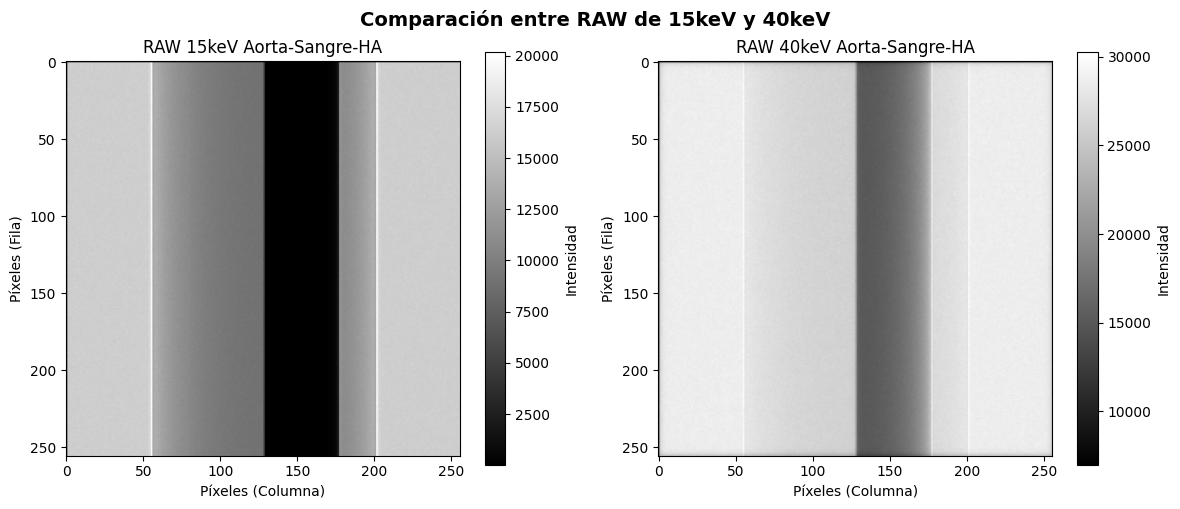

In [2]:
import numpy as np
import matplotlib.pyplot as plt
raw1 = np.loadtxt(r"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones monocromaticas para Aorta, sangre y placa\RAW sumado\RAWPLACASANGRE_sum_15keV_1E10events.txt")
raw2 = np.loadtxt(r"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones monocromaticas para Aorta, sangre y placa\RAW sumado\RAWPLACASANGRE_sum_40keV_1E10events.txt")
ff = np.loadtxt(r"C:\Users\Esteban Gomez\OneDrive - Universidad de los Andes\Archivos universidad\Tesis Esteban\Simulaciones Geant4 por pesos\FF\FF txt\FF_por_Pesos_PMMA_15keV.txt")
# 2. GRAFICAR MAPA DE GROSOR HA/PLACA (Material 1)
# ----------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 
fig.suptitle('Comparación entre RAW de 15keV y 40keV', fontsize=14, fontweight='bold')
im1 = axes[0].imshow(
    raw1, 
    cmap='gray',  # Mapa de color: bueno para datos científicos
    origin='upper'# La convención usual para imágenes de datos es que (0,0) esté arriba
)
axes[0].set_title('RAW 15keV Aorta-Sangre-HA')
axes[0].set_xlabel('Píxeles (Columna)')
axes[0].set_ylabel('Píxeles (Fila)')

# Barra de color para el grosor del Material 1
plt.colorbar(im1, ax=axes[0], label='Intensidad')

im2 = axes[1].imshow(
    raw2, 
    cmap='gray',  # Usamos un cmap diferente para distinguirlo visualmente
    origin='upper'
)
axes[1].set_title('RAW 40keV Aorta-Sangre-HA')
axes[1].set_xlabel('Píxeles (Columna)')
axes[1].set_ylabel('Píxeles (Fila)')

# Barra de color para el grosor del Material 2
plt.colorbar(im2, ax=axes[1], label='Intensidad')

# 4. Mostrar el gráfico
plt.tight_layout() # Ajusta automáticamente los subplots para que no se superpongan
plt.show()




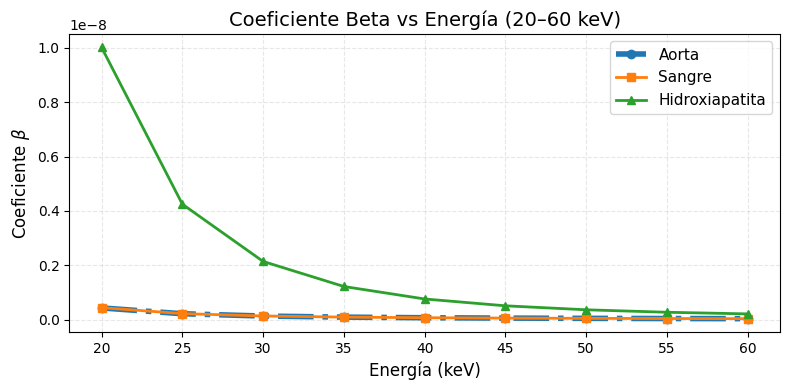

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# --- Datos ---
Beta_Aorta = np.array([4.3099E-10, 2.1691E-10, 1.3266E-10, 9.224E-11,
                       7.0062E-11, 5.6566E-11, 4.7400E-11, 4.0979E-11, 3.5999E-11])

Beta_HA = np.array([1.0015E-08, 4.2474E-09, 2.1410E-09, 1.2194E-09,
                    7.6015E-10, 5.0880E-10, 3.6230E-10, 2.7129E-10, 2.1123E-10])

Beta_Sangre = np.array([4.4151E-10, 2.2131E-10, 1.3484E-10, 9.3426E-11,
                        7.0748E-11, 5.6989E-11, 4.7676E-11, 4.1178E-11, 3.6148E-11])

energias = np.arange(20, 65, 5)

# --- Figura ---
plt.figure(figsize=(8,4))

# Aorta primero, así queda por encima
plt.plot(energias, Beta_Aorta, linestyle='-.', marker='o',
         color='tab:blue', linewidth=4, markersize=6, label='Aorta')

plt.plot(energias, Beta_Sangre, linestyle='-', marker='s',
         color='tab:orange', linewidth=2, markersize=6, label='Sangre')

plt.plot(energias, Beta_HA, linestyle='-', marker='^',
         color='tab:green', linewidth=2, markersize=6, label='Hidroxiapatita')

plt.grid(alpha=0.3, linestyle='--')
plt.xlabel("Energía (keV)", fontsize=12)
plt.ylabel(r"Coeficiente $\beta$", fontsize=12)
plt.title("Coeficiente Beta vs Energía (20–60 keV)", fontsize=14)
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()
